In [1]:
from dataclasses import dataclass
from functools import cached_property
import os
from pathlib import Path 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

In [2]:
@dataclass
class FaceAnnotation:
    major_ax_radius: float
    minor_ax_radius: float
    angle: float
    center_x: float 
    center_y: float 

    @classmethod
    def from_str(cls, datastr: str):
        anno = [float(coord) for coord in datastr.split()[:-1]]
        return cls(*anno)
    
    @cached_property
    def rot_mtx(self):
        return np.array(
            [
                [np.cos(self.angle), -np.sin(self.angle)],
                [np.sin(self.angle), np.cos(self.angle)]
            ]
        )
    
    @property
    def center(self):
        return np.array([self.center_x, self.center_y])

    @property
    def radii(self):
        return np.array([self.major_ax_radius, self.minor_ax_radius])

    @property
    def major_ax_bounds(self):
        major_bounds = np.tile(self.center[np.newaxis, :], (2, 1))
        major_bounds[0, 0] -= self.major_ax_radius
        major_bounds[1, 0] += self.major_ax_radius
        major_bounds = self.__rotate(major_bounds)
        return major_bounds.flatten().tolist()

    @property
    def minor_ax_bounds(self):
        minor_bounds = np.tile(self.center[np.newaxis, :], (2, 1))
        minor_bounds[0, 1] -= self.minor_ax_radius
        minor_bounds[1, 1] += self.minor_ax_radius
        minor_bounds = self.__rotate(minor_bounds)
        return minor_bounds.flatten().tolist()
    
    @property
    def bbox_corners(self):
        bbox_corners = np.tile(self.center[np.newaxis, :], (2, 1))
        bbox_corners[0, :] -= self.radii
        bbox_corners[1, :] += self.radii
        return bbox_corners.flatten().tolist()

    def __rotate(self, points:np.ndarray):
        """points of shape (N, 2)"""

        rotated = (points - self.center[np.newaxis, :]) @ self.rot_mtx.transpose() 
        rotated += self.center[np.newaxis, :]
        return rotated
            

class FaceImage:
    def __init__(self, file_path: Path, num_faces:int):
        self.file_path = file_path
        self.num_faces = num_faces
        self.faces: dict[int, FaceAnnotation] = {}
    
    def add_face(self, anno: FaceAnnotation):
        face_id = len(self.faces)
        self.faces[face_id] = anno

    def read_image(self):
        return Image.open(self.file_path)
    
    def show_annotated_image(self):
        face_img = self.read_image().convert("RGBA")
        drawing = ImageDraw.Draw(face_img)

        for face_anno in self.faces.values():
            drawing.line(
                face_anno.major_ax_bounds,
                fill="blue",
                width=2
            )
            drawing.line(
                face_anno.minor_ax_bounds,
                fill="blue",
                width=2
            )

            ellipse_img = Image.new('RGBA', face_img.size, (0, 0, 0, 0))
            ellipse_draw = ImageDraw.Draw(ellipse_img)
            ellipse_draw.ellipse(face_anno.bbox_corners, outline="blue", width=2)
            ellipse_img = ellipse_img.rotate(
                np.rad2deg(-face_anno.angle), center=face_anno.center.tolist()
            )
            face_img.paste(ellipse_img, (0, 0), ellipse_img)
        
        return face_img

    def __str__(self):
        face_word = "faces" if self.num_faces > 1 else "face"
        return f"{str(self.file_path)} has {self.num_faces} {face_word}."
    

In [3]:
data_dir = os.environ.get("DATASETS")
data_dir = Path(data_dir)
faces_dir = data_dir / "originalPics"
fold_dir = data_dir / "FDDB-folds"

fold_id = 1

fold_file = fold_dir / f"FDDB-fold-{fold_id:02d}.txt"
fold_ellipse_file = fold_dir / f"FDDB-fold-{fold_id:02d}-ellipseList.txt"

In [4]:
with open(fold_file, "r") as fid:
    fold_imgs = fid.read().splitlines()

In [5]:
face_images: list[FaceImage] = []

with open(fold_ellipse_file, "r") as fid:
    while True:
        line = fid.readline()
        
        if not line:
            break

        if line.endswith("\n"):
            line = line[:-1]

        assert line.startswith("2002") or line.startswith("2003")
        assert line in fold_imgs
        
        face_img_path = faces_dir / (line + ".jpg")
        num_faces = int(fid.readline())
        face_img = FaceImage(file_path=face_img_path, num_faces=num_faces)
        
        for _ in range(num_faces):
            face_anno = FaceAnnotation.from_str(fid.readline())
            face_img.add_face(face_anno)

        face_images.append(face_img)

In [6]:
img_with_most_faces = face_images[0]
for face_img in face_images[1:]:
    if face_img.num_faces > img_with_most_faces.num_faces:
        img_with_most_faces = face_img

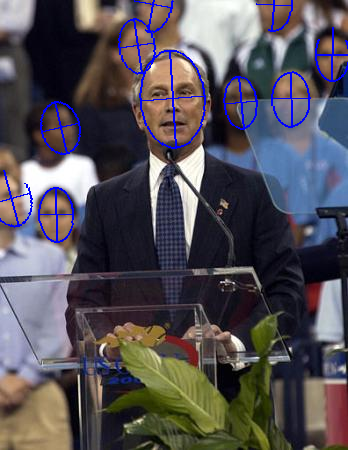

In [7]:
img = img_with_most_faces.show_annotated_image()
img